In [1]:
### Importar librerias necesarias
%load_ext autoreload
%autoreload 2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from feature_engine.imputation import MeanMedianImputer
from feature_engine.outliers import Winsorizer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from utils import ScalerDf, Kmeans_
import joblib

# Sobre el Dataset
Este caso requiere desarrollar una segmentación de clientes para definir una estrategia de marketing. El conjunto de datos de muestra resume el comportamiento de uso de aproximadamente 9000 titulares de tarjetas de crédito activos durante los últimos 6 meses. El archivo está a nivel de cliente y contiene 18 variables de comportamiento.

- **CUST_ID**: Identificación del titular de la tarjeta de crédito (Categórica)
- **BALANCE**: Saldo restante en la cuenta para realizar compras.
- **BALANCE_FREQUENCY**: Con qué frecuencia se actualiza el saldo, puntuación entre 0 y 1 (1 = actualizado con frecuencia, 0 = no actualizado con frecuencia).
- **PURCHASES**: Monto de las compras realizadas desde la cuenta.
- **ONEOFF_PURCHASES**: Monto máximo de compra realizado de una sola vez.
- **INSTALLMENTS_PURCHASES**: Monto de compra realizado a plazos.
- **CASH_ADVANCE**: Dinero en efectivo otorgado por el usuario.
- **PURCHASES_FREQUENCY**: Con qué frecuencia se realizan las compras, puntuación entre 0 y 1 (1 = compras frecuentes, 0 = compras no frecuentes).
- **ONEOFFPURCHASESFREQUENCY**: Con qué frecuencia se realizan compras de una sola vez (1 = compras frecuentes, 0 = compras no frecuentes).
- **PURCHASESINSTALLMENTSFREQUENCY**: Con qué frecuencia se realizan compras a plazos (1 = frecuentemente realizadas, 0 = no frecuentemente realizadas).
- **CASHADVANCEFREQUENCY**: Con qué frecuencia se paga el dinero en efectivo por adelantado.
- **CASHADVANCETRX**: Número de transacciones realizadas con "dinero en efectivo por adelantado".
- **PURCHASES_TRX**: Número de transacciones de compra realizadas.
- **CREDIT_LIMIT**: Límite de la tarjeta de crédito para el usuario.
- **PAYMENTS**: Monto de los pagos realizados por el usuario.
- **MINIMUM_PAYMENTS**: Monto mínimo de los pagos realizados por el usuario.
- **PRCFULLPAYMENT**: Porcentaje del pago total realizado por el usuario.
- **TENURE**: Duración del servicio de la tarjeta de crédito para el usuario.

## Lectura de datos

In [2]:
cc_data = pd.read_csv('./../data/raw/raw_data.csv', index_col='CUST_ID')
print(cc_data.shape)
cc_data.head()

(8950, 17)


,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
CUST_ID,,,,,,,,,,,,,,,,,
C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [3]:
### últimos 50 registros para testear.
test_data = cc_data.iloc[-50:]
cc_data.drop(cc_data.iloc[-50:].index, inplace=True)
print('Training data', cc_data.shape)
print('Test Data', test_data.shape)

Training data (8900, 17)
Test Data (50, 17)


In [4]:
## Estadísticas descriptivas
cc_data.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8900.000000,8900.000000,8900.000000,8900.000000,8900.000000,8900.000000,8900.000000,8900.000000,8900.000000,8900.000000,8900.000000,8900.000000,8899.000000,8900.000000,8592.000000,8900.000000,8900.000000
mean,1571.414570,0.877625,1006.971155,595.044008,412.229016,981.899111,0.489496,0.203154,0.363764,0.135307,3.256966,14.761011,4511.543784,1740.888372,868.091128,0.152833,11.546966
std,2084.283867,0.236965,2141.861902,1664.042754,906.580277,2100.445860,0.401316,0.298787,0.397559,0.200167,6.837817,24.914315,3640.687166,2900.895763,2378.022151,0.291898,1.281722
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,130.619985,0.888889,38.912500,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,386.654957,169.885253,0.000000,12.000000
50%,881.891099,1.000000,363.450000,40.000000,88.590000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,862.816365,314.850916,0.000000,12.000000
75%,2066.860452,1.000000,1116.277500,583.335000,469.725000,1116.385348,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1908.840688,830.480676,0.142857,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


## Identificando Variables con valores faltantes

In [5]:

cc_data.isna().sum().sort_values(ascending=False)

MINIMUM_PAYMENTS                    308
CREDIT_LIMIT                          1
BALANCE                               0
CASH_ADVANCE_FREQUENCY                0
PRC_FULL_PAYMENT                      0
PAYMENTS                              0
PURCHASES_TRX                         0
CASH_ADVANCE_TRX                      0
PURCHASES_INSTALLMENTS_FREQUENCY      0
BALANCE_FREQUENCY                     0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_FREQUENCY                   0
CASH_ADVANCE                          0
INSTALLMENTS_PURCHASES                0
ONEOFF_PURCHASES                      0
PURCHASES                             0
TENURE                                0
dtype: int64

In [6]:
imputer =  MeanMedianImputer(imputation_method='mean', variables= ['MINIMUM_PAYMENTS', 'CREDIT_LIMIT'])
cc_data_transformed = imputer.fit_transform(cc_data)
cc_data_transformed.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
CUST_ID,,,,,,,,,,,,,,,,,
C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,868.091128,0.000000,12
C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [7]:
cc_data_transformed.isna().sum().sort_values(ascending=False)

BALANCE                             0
CASH_ADVANCE_FREQUENCY              0
PRC_FULL_PAYMENT                    0
MINIMUM_PAYMENTS                    0
PAYMENTS                            0
CREDIT_LIMIT                        0
PURCHASES_TRX                       0
CASH_ADVANCE_TRX                    0
PURCHASES_INSTALLMENTS_FREQUENCY    0
BALANCE_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_FREQUENCY                 0
CASH_ADVANCE                        0
INSTALLMENTS_PURCHASES              0
ONEOFF_PURCHASES                    0
PURCHASES                           0
TENURE                              0
dtype: int64

In [8]:
## Primer paso del pipeline, imputar valores faltantes
pipeline_steps = [
('mean_inputer', MeanMedianImputer(imputation_method='mean', variables= ['MINIMUM_PAYMENTS', 'CREDIT_LIMIT']))
] 

## Identificar Valores Atipicos

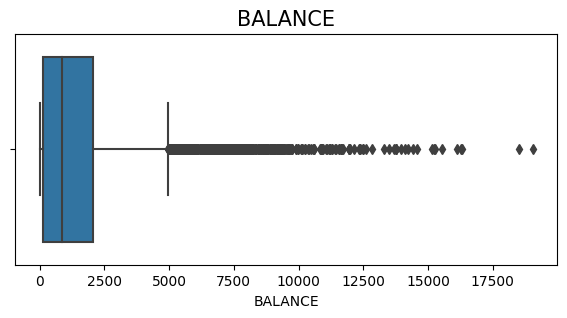

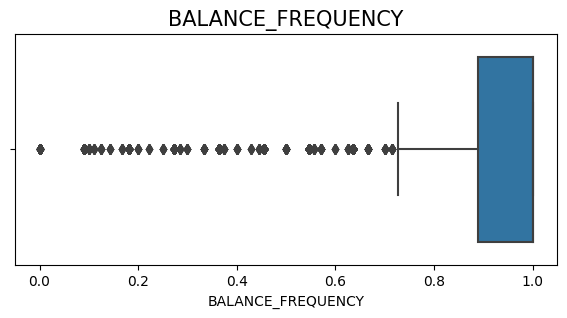

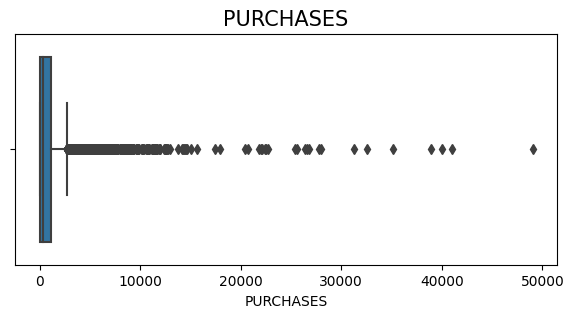

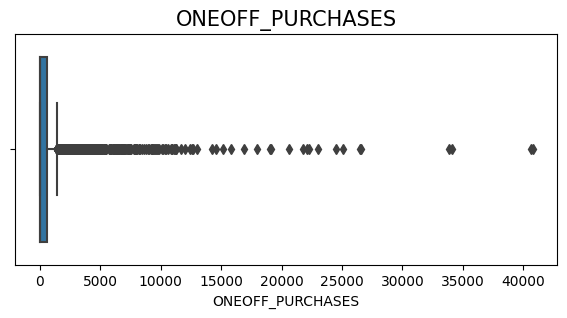

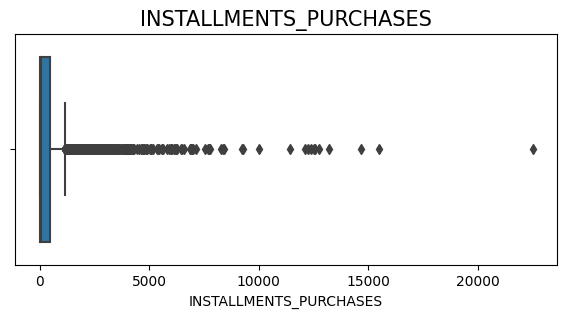

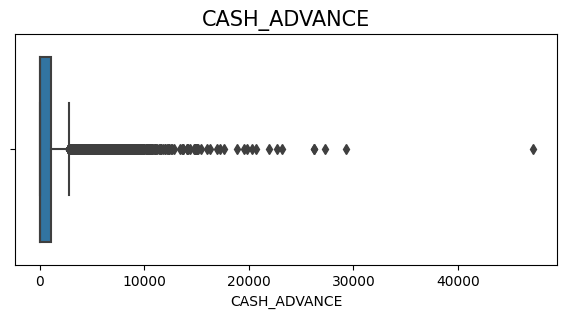

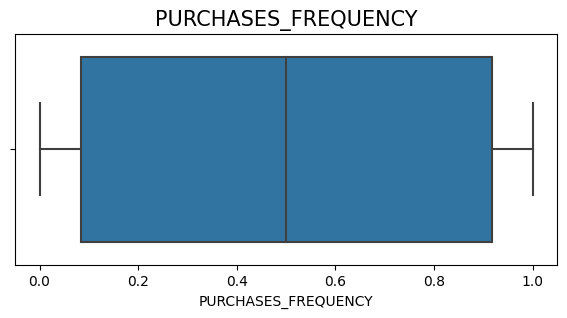

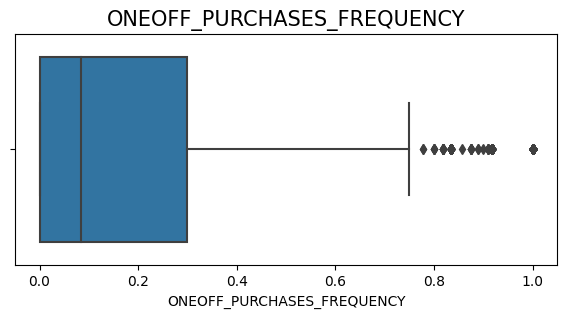

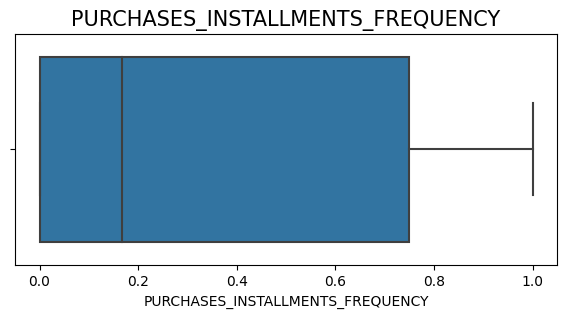

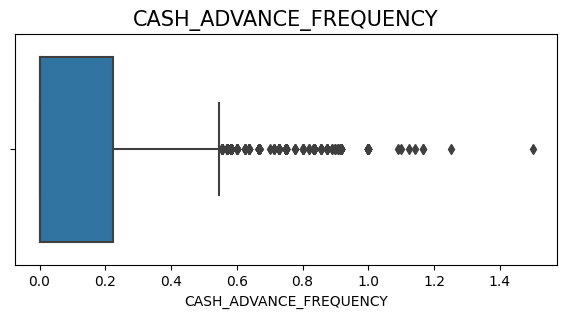

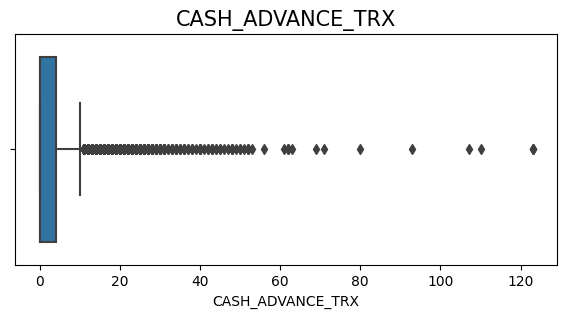

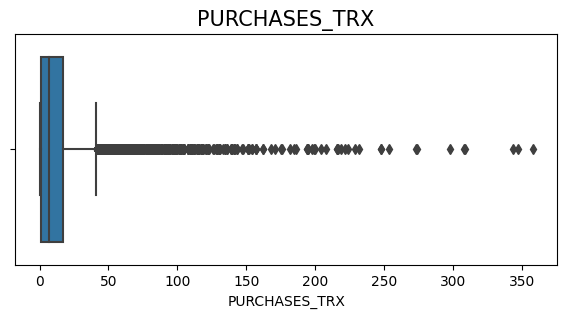

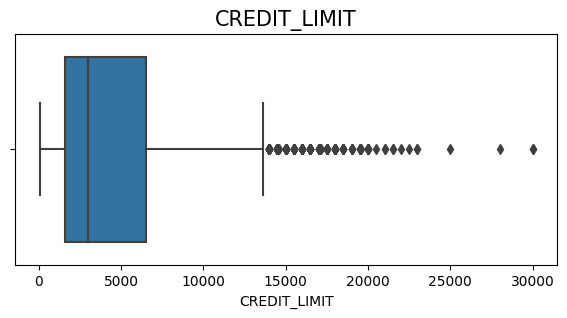

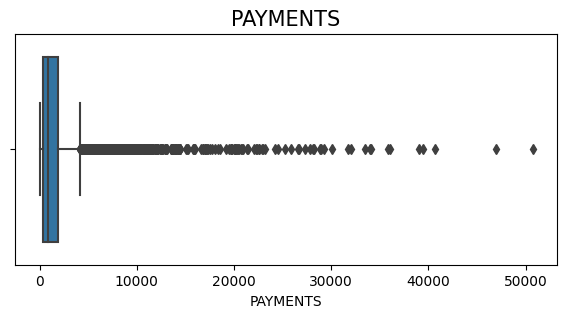

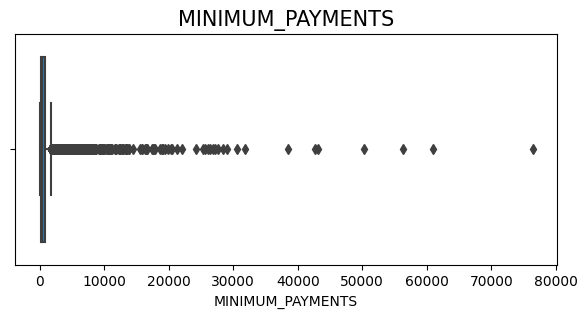

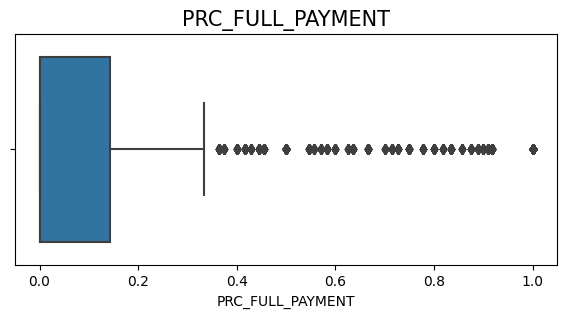

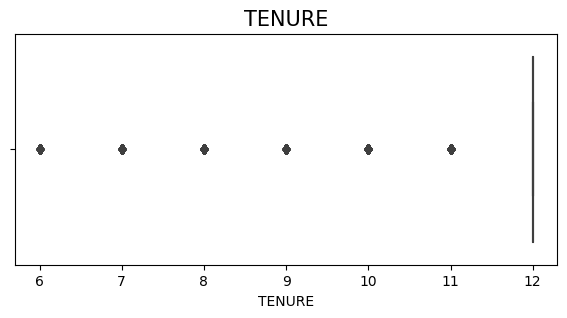

In [9]:
for col in cc_data.columns:
    
    fig, ax = plt.subplots(figsize=(7, 3))
    
    sns.boxplot(x=cc_data[col], ax=ax)
   
    ax.set_title(col, fontsize=15)

    plt.show()

In [10]:
outliers_features= ['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 
                    'CASH_ADVANCE', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
                    'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS',
                    'PRC_FULL_PAYMENT']
## Estimo el winsorizer a las variables con atipicos
wr = Winsorizer(capping_method='iqr', variables=outliers_features, tail='both', fold=1.5)
cc_data_transformed = wr.fit_transform(cc_data_transformed)
cc_data_transformed.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
CUST_ID,,,,,,,,,,,,,,,,,
C10001,40.900749,0.818182,95.40,0.0000,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
C10002,3202.467416,0.909091,0.00,0.0000,0.0,2790.963370,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
C10003,2495.148862,1.000000,773.17,773.1700,0.0,0.000000,1.000000,0.750000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
C10004,1666.670542,0.722223,1499.00,1458.3375,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,868.091128,0.000000,12
C10005,817.714335,1.000000,16.00,16.0000,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


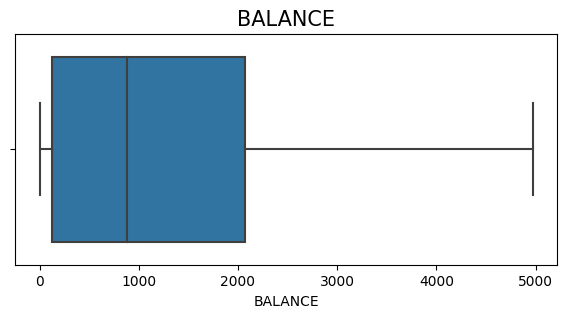

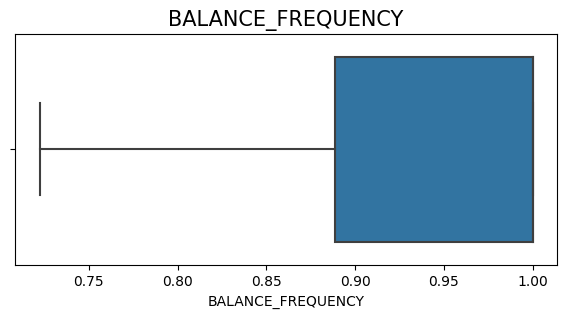

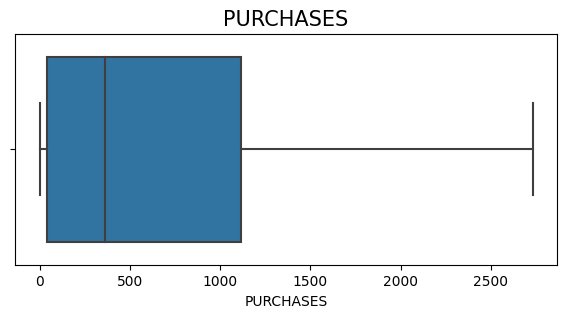

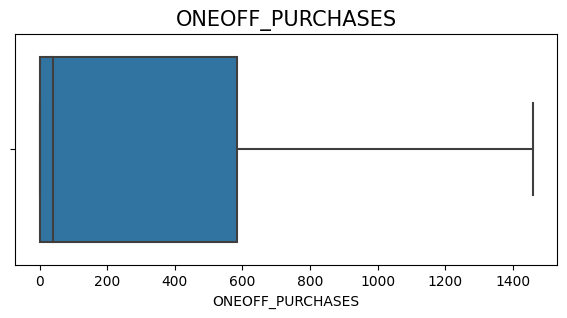

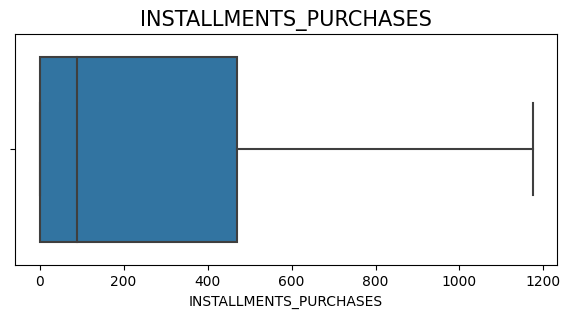

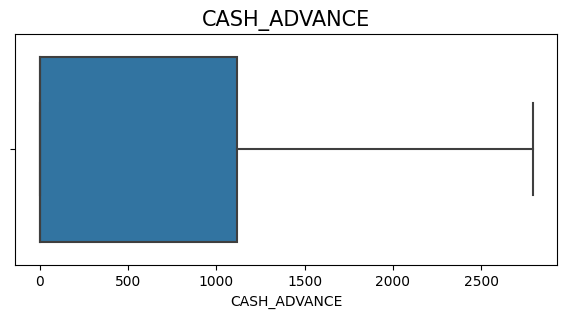

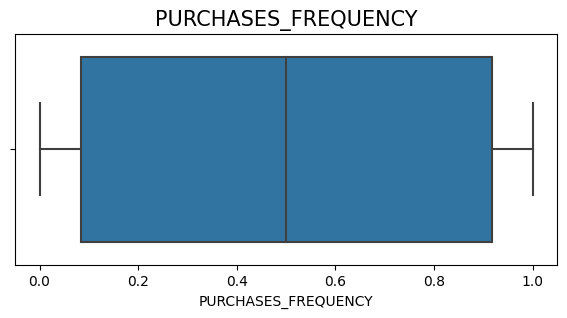

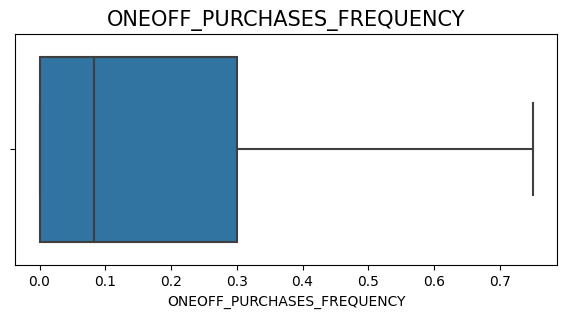

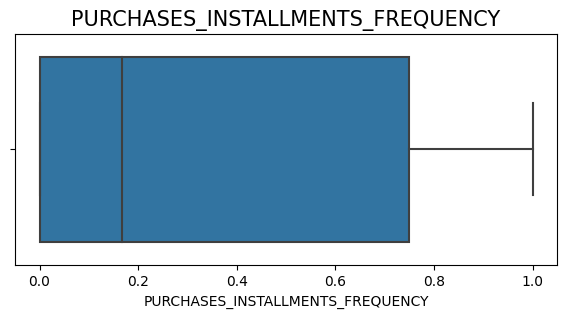

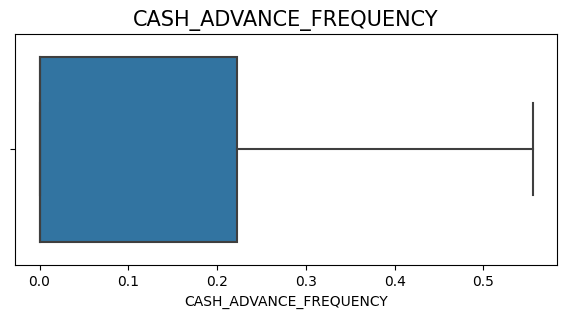

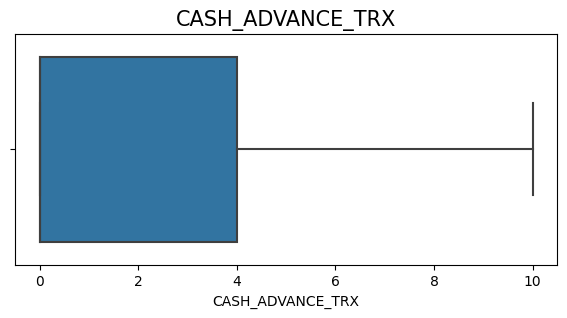

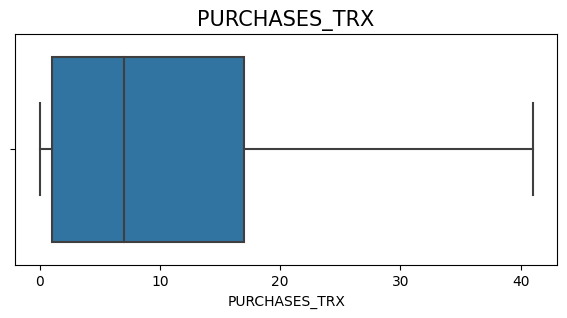

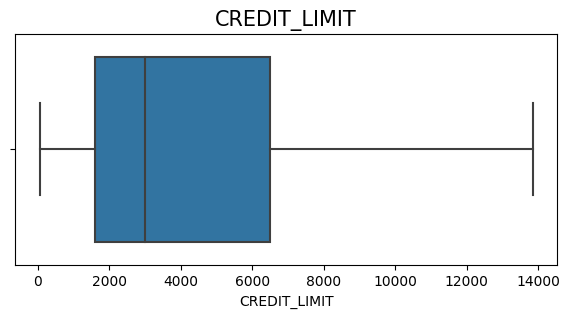

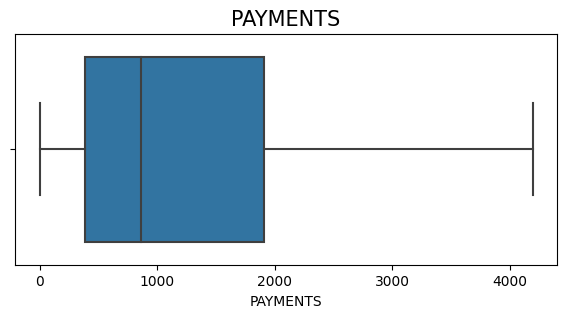

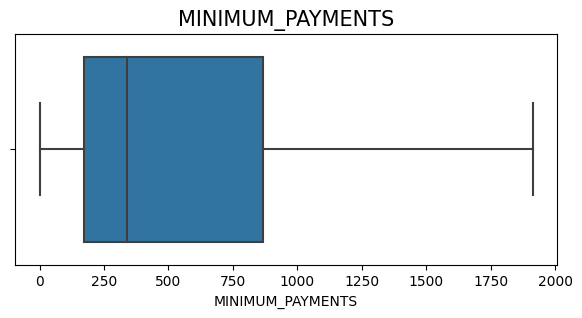

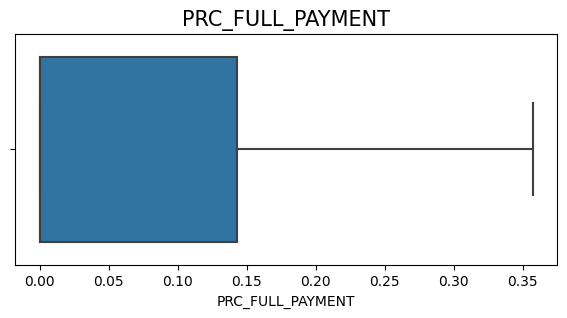

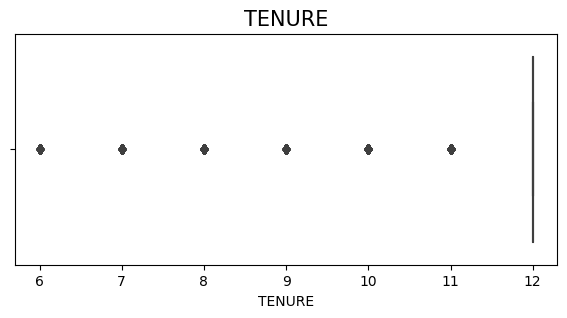

In [11]:
for col in cc_data_transformed.columns:
    
    fig, ax = plt.subplots(figsize=(7, 3))
    
    sns.boxplot(x=cc_data_transformed[col], ax=ax)
   
    ax.set_title(col, fontsize=15)

    plt.show()

In [12]:
### Agrego nuevo paso a mi pipeline: Tramiento de Atipicos
pipeline_steps.append(('outlier_handling', Winsorizer(capping_method='iqr', variables=outliers_features, tail='both', fold=1.5)))

## Estandarización de los datos

In [13]:
tes = cc_data_transformed.copy()

In [14]:
scaler = ScalerDf(method='minmax')
scaler.fit(cc_data_transformed)
cc_data_transformed_scaled = scaler.transform(cc_data_transformed)
cc_data_transformed_scaled.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
CUST_ID,,,,,,,,,,,,,,,,,
C10001,0.008228,0.345455,0.034915,0.000000,0.081239,0.000000,0.166667,0.000000,0.083333,0.00,0.0,0.048780,0.068841,0.048138,0.072914,0.000000,1.0
C10002,0.644201,0.672727,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.45,0.4,0.000000,0.503623,0.978749,0.560519,0.622222,1.0
C10003,0.501919,1.000000,0.282971,0.530172,0.000000,0.000000,1.000000,1.000000,0.000000,0.00,0.0,0.292683,0.539855,0.148390,0.327882,0.000000,1.0
C10004,0.335264,0.000000,0.548617,1.000000,0.000000,0.073734,0.083333,0.111111,0.000000,0.15,0.1,0.024390,0.539855,0.000000,0.453755,0.000000,1.0
C10005,0.164490,1.000000,0.005856,0.010971,0.000000,0.000000,0.083333,0.111111,0.000000,0.00,0.0,0.024390,0.083333,0.161812,0.127946,0.000000,1.0


In [15]:
cc_data_transformed.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
CUST_ID,,,,,,,,,,,,,,,,,
C10001,40.900749,0.818182,95.40,0.0000,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
C10002,3202.467416,0.909091,0.00,0.0000,0.0,2790.963370,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
C10003,2495.148862,1.000000,773.17,773.1700,0.0,0.000000,1.000000,0.750000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
C10004,1666.670542,0.722223,1499.00,1458.3375,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,868.091128,0.000000,12
C10005,817.714335,1.000000,16.00,16.0000,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [16]:
from sklearn.preprocessing import MinMaxScaler

In [17]:
tes

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
CUST_ID,,,,,,,,,,,,,,,,,
C10001,40.900749,0.818182,95.400,0.0000,95.40,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
C10002,3202.467416,0.909091,0.000,0.0000,0.00,2790.963370,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
C10003,2495.148862,1.000000,773.170,773.1700,0.00,0.000000,1.000000,0.750000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
C10004,1666.670542,0.722223,1499.000,1458.3375,0.00,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,868.091128,0.000000,12
C10005,817.714335,1.000000,16.000,16.0000,0.00,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C19136,893.949463,0.857143,958.800,958.8000,0.00,566.910978,0.571429,0.571429,0.000000,0.142857,2,22,1200.0,590.785658,624.530535,0.000000,7
C19137,1117.594403,1.000000,291.620,0.0000,291.62,1596.771919,1.000000,0.000000,0.857143,0.142857,2,7,2000.0,74.055925,382.846205,0.000000,7
C19138,328.686581,1.000000,2732.325,1458.3375,218.25,0.000000,0.857143,0.714286,0.285714,0.000000,0,26,1200.0,1796.886852,93.017466,0.250000,7


In [18]:
scaler1 = MinMaxScaler()
scaler1.fit(tes)
pd.DataFrame(scaler1.transform(tes.iloc[0:2]))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.008228,0.345455,0.034915,0.0,0.081239,0.0,0.166667,0.0,0.083333,0.00,0.0,0.04878,0.068841,0.048138,0.072914,0.000000,1.0
1,0.644201,0.672727,0.000000,0.0,0.000000,1.0,0.000000,0.0,0.000000,0.45,0.4,0.00000,0.503623,0.978749,0.560519,0.622222,1.0


In [19]:
tes.iloc[0:2]

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
CUST_ID,,,,,,,,,,,,,,,,,
C10001,40.900749,0.818182,95.4,0.0,95.4,0.00000,0.166667,0.0,0.083333,0.00,0,2,1000.0,201.802084,139.509787,0.000000,12
C10002,3202.467416,0.909091,0.0,0.0,0.0,2790.96337,0.000000,0.0,0.000000,0.25,4,0,7000.0,4103.032597,1072.340217,0.222222,12


In [20]:
from utils import ScalerDf
scaler2 = ScalerDf(method='minmax')
scaler2.fit(tes)
scaler2.transform(tes.head(10))

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
CUST_ID,,,,,,,,,,,,,,,,,
C10001,0.008228,0.345455,0.034915,0.000000,0.081239,0.000000,0.166667,0.000000,0.083333,0.00,0.0,0.048780,0.068841,0.048138,0.072914,0.000000,1.0
C10002,0.644201,0.672727,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.45,0.4,0.000000,0.503623,0.978749,0.560519,0.622222,1.0
C10003,0.501919,1.000000,0.282971,0.530172,0.000000,0.000000,1.000000,1.000000,0.000000,0.00,0.0,0.292683,0.539855,0.148390,0.327882,0.000000,1.0
C10004,0.335264,0.000000,0.548617,1.000000,0.000000,0.073734,0.083333,0.111111,0.000000,0.15,0.1,0.024390,0.539855,0.000000,0.453755,0.000000,1.0
C10005,0.164490,1.000000,0.005856,0.010971,0.000000,0.000000,0.083333,0.111111,0.000000,0.00,0.0,0.024390,0.083333,0.161812,0.127946,0.000000,1.0
C10006,0.364061,1.000000,0.487965,0.000000,1.000000,0.000000,0.666667,0.000000,0.583333,0.00,0.0,0.195122,0.126812,0.333974,1.000000,0.000000,1.0
C10007,0.126178,1.000000,1.000000,1.000000,0.586198,0.000000,1.000000,1.000000,1.000000,0.00,0.0,1.000000,0.974638,1.000000,0.103522,1.000000,1.0
C10008,0.366842,1.000000,0.159644,0.000000,0.371451,0.000000,1.000000,0.000000,1.000000,0.00,0.0,0.292683,0.163043,0.161986,0.278092,0.000000,1.0
C10009,0.204160,1.000000,0.315296,0.453592,0.170312,0.000000,0.333333,0.111111,0.250000,0.00,0.0,0.121951,0.503623,0.164184,0.163058,0.000000,1.0


In [21]:
scaler2 = ScalerDf(method='minmax')
scaler2.fit_transform(tes)
scaler2.transform(tes.head())

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
CUST_ID,,,,,,,,,,,,,,,,,
C10001,0.008228,0.345455,0.034915,0.000000,0.081239,0.000000,0.166667,0.000000,0.083333,0.00,0.0,0.048780,0.068841,0.048138,0.072914,0.000000,1.0
C10002,0.644201,0.672727,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.45,0.4,0.000000,0.503623,0.978749,0.560519,0.622222,1.0
C10003,0.501919,1.000000,0.282971,0.530172,0.000000,0.000000,1.000000,1.000000,0.000000,0.00,0.0,0.292683,0.539855,0.148390,0.327882,0.000000,1.0
C10004,0.335264,0.000000,0.548617,1.000000,0.000000,0.073734,0.083333,0.111111,0.000000,0.15,0.1,0.024390,0.539855,0.000000,0.453755,0.000000,1.0
C10005,0.164490,1.000000,0.005856,0.010971,0.000000,0.000000,0.083333,0.111111,0.000000,0.00,0.0,0.024390,0.083333,0.161812,0.127946,0.000000,1.0


In [22]:
scaler2.transform(tes.iloc[0:5])

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
CUST_ID,,,,,,,,,,,,,,,,,
C10001,0.008228,0.345455,0.034915,0.000000,0.081239,0.000000,0.166667,0.000000,0.083333,0.00,0.0,0.048780,0.068841,0.048138,0.072914,0.000000,1.0
C10002,0.644201,0.672727,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.45,0.4,0.000000,0.503623,0.978749,0.560519,0.622222,1.0
C10003,0.501919,1.000000,0.282971,0.530172,0.000000,0.000000,1.000000,1.000000,0.000000,0.00,0.0,0.292683,0.539855,0.148390,0.327882,0.000000,1.0
C10004,0.335264,0.000000,0.548617,1.000000,0.000000,0.073734,0.083333,0.111111,0.000000,0.15,0.1,0.024390,0.539855,0.000000,0.453755,0.000000,1.0
C10005,0.164490,1.000000,0.005856,0.010971,0.000000,0.000000,0.083333,0.111111,0.000000,0.00,0.0,0.024390,0.083333,0.161812,0.127946,0.000000,1.0


In [38]:
scaler2.scaler.data_max_

AttributeError: 'ScalerDf' object has no attribute 'scaler'

In [37]:
scaler1.data_max_

array([4.97122115e+03, 1.00000000e+00, 2.73232500e+03, 1.45833750e+03,
       1.17431250e+03, 2.79096337e+03, 1.00000000e+00, 7.50000000e-01,
       1.00000000e+00, 5.55555000e-01, 1.00000000e+01, 4.10000000e+01,
       1.38500000e+04, 4.19211929e+03, 1.91310507e+03, 3.57142500e-01,
       1.20000000e+01])

In [43]:
tes.iloc[0:8]

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
CUST_ID,,,,,,,,,,,,,,,,,
C10001,40.900749,0.818182,95.400,0.0000,95.4000,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
C10002,3202.467416,0.909091,0.000,0.0000,0.0000,2790.963370,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
C10003,2495.148862,1.000000,773.170,773.1700,0.0000,0.000000,1.000000,0.750000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
C10004,1666.670542,0.722223,1499.000,1458.3375,0.0000,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,868.091128,0.000000,12
C10005,817.714335,1.000000,16.000,16.0000,0.0000,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12
C10006,1809.828751,1.000000,1333.280,0.0000,1174.3125,0.000000,0.666667,0.000000,0.583333,0.000000,0,8,1800.0,1400.057770,1913.105073,0.000000,12
C10007,627.260806,1.000000,2732.325,1458.3375,688.3800,0.000000,1.000000,0.750000,1.000000,0.000000,0,41,13500.0,4192.119285,198.065894,0.357143,12
C10008,1823.652743,1.000000,436.200,0.0000,436.2000,0.000000,1.000000,0.000000,1.000000,0.000000,0,12,2300.0,679.065082,532.033990,0.000000,12


In [64]:
scaler.transform(cc_data_transformed.iloc[0:9])

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
CUST_ID,,,,,,,,,,,,,,,,,
C10001,0.000000,0.345455,0.034915,0.000000,0.081239,0.000000,0.166667,0.000000,0.083333,0.000000,0.00,0.048780,0.000,0.048138,0.000000,0.000000,0.0
C10002,1.000000,0.672727,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.00,0.000000,0.480,0.978749,0.525955,0.622222,0.0
C10003,0.776276,1.000000,0.282971,0.530172,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.00,0.292683,0.520,0.148390,0.275020,0.000000,0.0
C10004,0.514229,0.000000,0.548617,1.000000,0.000000,0.073734,0.083333,0.111111,0.000000,0.333332,0.25,0.024390,0.520,0.000000,0.410793,0.000000,0.0
C10005,0.245705,1.000000,0.005856,0.010971,0.000000,0.000000,0.083333,0.111111,0.000000,0.000000,0.00,0.024390,0.016,0.161812,0.059360,0.000000,0.0
C10006,0.559510,1.000000,0.487965,0.000000,1.000000,0.000000,0.666667,0.000000,0.583333,0.000000,0.00,0.195122,0.064,0.333974,1.000000,0.000000,0.0
C10007,0.185465,1.000000,1.000000,1.000000,0.586198,0.000000,1.000000,1.000000,1.000000,0.000000,0.00,1.000000,1.000,1.000000,0.033015,1.000000,0.0
C10008,0.563882,1.000000,0.159644,0.000000,0.371451,0.000000,1.000000,0.000000,1.000000,0.000000,0.00,0.292683,0.104,0.161986,0.221316,0.000000,0.0
C10009,0.308083,1.000000,0.315296,0.453592,0.170312,0.000000,0.333333,0.111111,0.250000,0.000000,0.00,0.121951,0.480,0.164184,0.097234,0.000000,0.0


In [15]:
### Agrego paso de estandarizacion a mi pipeline
pipeline_steps.append(('standard', ScalerDf(method='minmax')))

# Analisis de componentes principales

In [21]:
pca = PCA(n_components=2)
cc_data_transformed =  pca.fit_transform(cc_data_transformed)

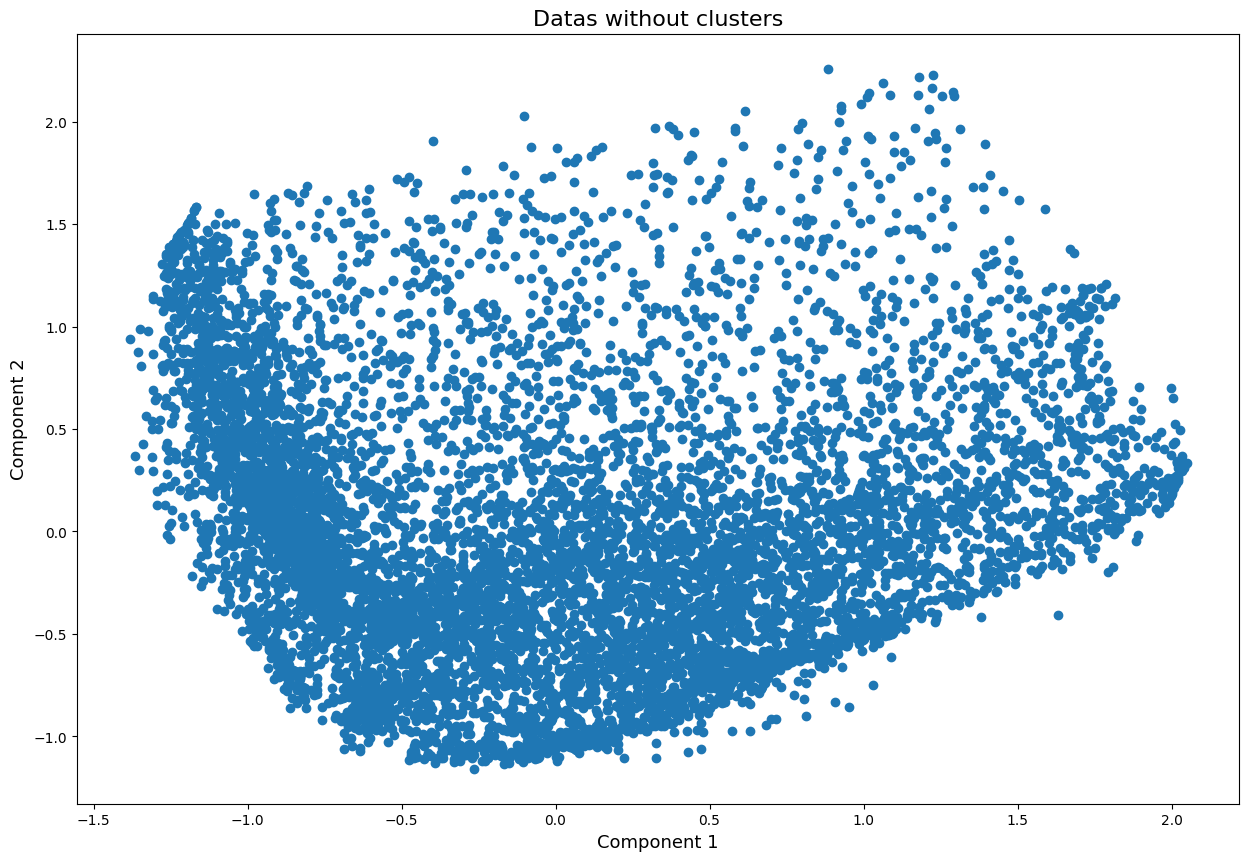

In [22]:
### Grafico componentes principales
fig, ax = plt.subplots(figsize=(15, 10))

ax.scatter(cc_data_transformed[:, 0], cc_data_transformed[:, 1])

ax.set_title('Datas without clusters', fontsize=16)

ax.set_xlabel('Component 1', fontsize=13)
ax.set_ylabel('Component 2', fontsize=13)

plt.show()

In [23]:
pca.explained_variance_ratio_

array([0.34551185, 0.22202865])

In [24]:
### Agrego PCA a mi pipeline
pipeline_steps.append(('PCA', PCA(n_components=2)))

### Algoritmo K-Means

In [25]:
k_means = Kmeans_(n_clusters=4)
k_means.fit_transform(cc_data_transformed)

,0,1,label
0,-0.565104,-0.798480,3
1,-0.857553,0.566860,0
2,0.382732,0.125604,1
3,-0.300091,-0.202927,3
4,-0.582457,-0.475777,3
...,...,...,...
8895,0.056531,-0.013869,1
8896,0.032871,-0.050061,1
8897,1.103300,-0.078048,2
8898,-0.123566,-0.506465,3


In [26]:
### Agrego kmeans a mi pipeline
pipeline_steps.append(('Kmeans',Kmeans_(n_clusters=4)))

## Pongamos todo junto

In [27]:
pipeline_steps

[('mean_inputer',
  MeanMedianImputer(imputation_method='mean',
                    variables=['MINIMUM_PAYMENTS', 'CREDIT_LIMIT'])),
 ('outlier_handling',
  Winsorizer(capping_method='iqr', fold=1.5, tail='both',
             variables=['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES',
                        'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES',
                        'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
                        'ONEOFF_PURCHASES_FREQUENCY',
                        'PURCHASES_INSTALLMENTS_FREQUENCY',
                        'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX',
                        'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS',
                        'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT'])),
 ('standard', ScalerDf(method='minmax')),
 ('PCA', PCA(n_components=2)),
 ('Kmeans', Kmeans_(n_clusters=4))]

In [28]:
cluster_pipeline = Pipeline(pipeline_steps)
cluster_pipeline

Pipeline(steps=[('mean_inputer',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['MINIMUM_PAYMENTS',
                                              'CREDIT_LIMIT'])),
                ('outlier_handling',
                 Winsorizer(capping_method='iqr', fold=1.5, tail='both',
                            variables=['BALANCE', 'BALANCE_FREQUENCY',
                                       'PURCHASES', 'ONEOFF_PURCHASES',
                                       'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE',
                                       'PURCHASES_FREQUENCY',
                                       'ONEOFF_PURCHASES_FREQUENCY',
                                       'PURCHASES_INSTALLMENTS_FREQUENCY',
                                       'CASH_ADVANCE_FREQUENCY',
                                       'CASH_ADVANCE_TRX', 'PURCHASES_TRX',
                                       'CREDIT_LIMIT', 'PAYMENTS',
                                       'MINIMUM_PAYMENTS',
                                       'PRC_FULL_PAYMENT'])),
                ('standard', ScalerDf(method='minmax')),
                ('PCA', PCA(n_components=2)),
                ('Kmeans', Kmeans_(n_clusters=4))])

In [29]:
cluster_pipeline.fit(cc_data)

Pipeline(steps=[('mean_inputer',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['MINIMUM_PAYMENTS',
                                              'CREDIT_LIMIT'])),
                ('outlier_handling',
                 Winsorizer(capping_method='iqr', fold=1.5, tail='both',
                            variables=['BALANCE', 'BALANCE_FREQUENCY',
                                       'PURCHASES', 'ONEOFF_PURCHASES',
                                       'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE',
                                       'PURCHASES_FREQUENCY',
                                       'ONEOFF_PURCHASES_FREQUENCY',
                                       'PURCHASES_INSTALLMENTS_FREQUENCY',
                                       'CASH_ADVANCE_FREQUENCY',
                                       'CASH_ADVANCE_TRX', 'PURCHASES_TRX',
                                       'CREDIT_LIMIT', 'PAYMENTS',
                                       'MINIMUM_PAYMENTS',
                                       'PRC_FULL_PAYMENT'])),
                ('standard', ScalerDf(method='minmax')),
                ('PCA', PCA(n_components=2)),
                ('Kmeans', Kmeans_(n_clusters=4))])

In [30]:
cluster_results = cluster_pipeline.transform(cc_data)
cluster_results.head()

,0,1,label
0,-0.565104,-0.798480,2
1,-0.857553,0.566860,0
2,0.382732,0.125603,3
3,-0.300091,-0.202929,2
4,-0.582457,-0.475777,2


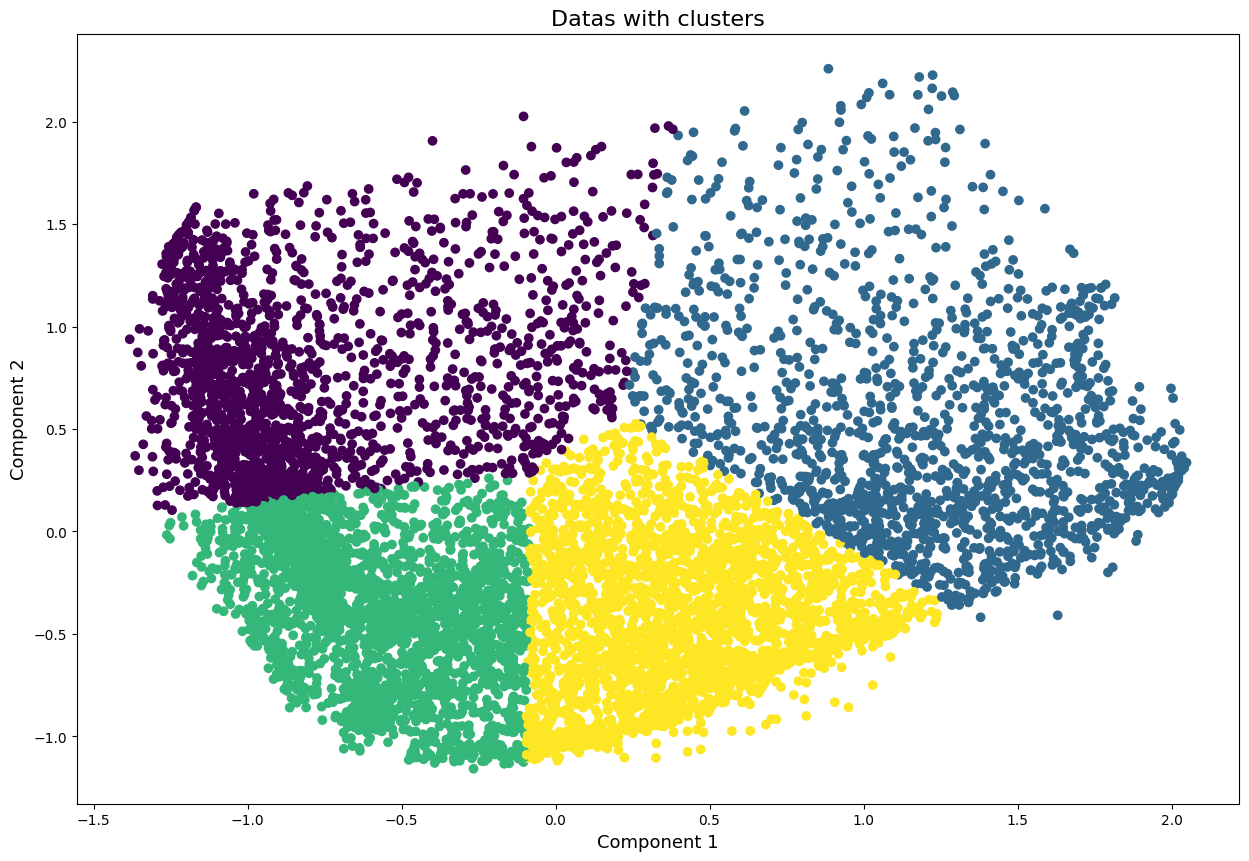

In [31]:
fig, ax = plt.subplots(figsize=(15, 10))

ax.scatter(cluster_results[0], cluster_results[1], c=cluster_results['label'])

ax.set_title('Datas with clusters', fontsize=16)

ax.set_xlabel('Component 1', fontsize=13)
ax.set_ylabel('Component 2', fontsize=13)

plt.show()

# Probando Pipeline con datos nuevos

In [33]:
test_data.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
CUST_ID,,,,,,,,,,,,,,,,,
C19141,25.302553,0.714286,176.25,0.00,176.25,0.000000,0.714286,0.000000,0.571429,0.000000,0,5,1500.0,191.780690,99.580177,0.000000,7
C19142,379.619245,0.857143,0.00,0.00,0.00,484.443319,0.000000,0.000000,0.000000,0.142857,3,0,500.0,93.745897,148.248169,0.000000,7
C19143,34.048983,1.000000,181.62,0.00,181.62,0.000000,0.857143,0.000000,0.714286,0.000000,0,6,1500.0,135.187785,101.820343,0.600000,7
C19144,466.723482,0.833333,947.21,498.01,449.20,0.000000,0.833333,0.333333,0.666667,0.000000,0,27,1500.0,38.775803,131.313627,0.000000,6
C19145,43.960637,1.000000,580.65,0.00,580.65,0.000000,1.000000,0.000000,0.857143,0.000000,0,7,1000.0,488.691925,103.514338,0.833333,7


In [32]:
## Estimaciones sobre nuevos datos
cluster_pipeline.transform(test_data)

,0,1,label
0,-0.030545,-0.851904,3
1,-0.865756,-0.477120,2
2,0.392999,-0.742013,3
3,0.818925,-0.369125,3
4,0.743710,-0.661783,3
5,0.159778,-1.025302,3
6,-0.313507,-0.604992,2
7,0.271335,-1.075140,3
8,0.546245,-0.739713,3
9,-0.234174,-0.264363,2


In [248]:
#joblib.dump(cluster_pipeline, 'cluster_pipeline.joblib')